In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gene_panel_selection import ExpressionDataset, ScranMethod, GeneBasisMethod, GenePanelSelection, gene_basis_panel_eval

In [2]:
directory = '//allen/programs/celltypes/workgroups/synphys/NHP_spatial/'

In [3]:
# load data

annotations = pd.read_feather(directory + 'anno.feather').set_index('sample_id')
genes = pd.read_feather(directory + 'genes.feather')
expression = pd.read_feather(directory + 'expression_matrix_cpm_normalized.feather')
expression = expression.set_index(genes['gene'])
annotations.head()

exp_data = ExpressionDataset(
    expression_data=expression,  # dataframe, one gene per row, index is gene names, columns are samples
    annotation_data=annotations,  # dataframe, index is sample names, has columns 'cluster', 'subclass', 'class'
    save_path = directory + 'gene_panel_runs' # path to save to for later recall
)

In [4]:
# transform to log counts
exp_data.logcounts()

In [6]:
# pre-select highly variable genes
hvg_selection = ScranMethod(exp_data=exp_data).select_gene_panel(size=None, args={})

In [7]:
hvg_selection.report()

{'n_genes_selected': 17527, 'variance_threshold': 0, 'used_log_counts': True, 'file_name': 'hvg_selection'}


In [4]:
hvg_exp_data = hvg_selection.expression_dataset()

In [5]:
# geneBasis gene selection
# first convert to SCE format

gene_basis = GeneBasisMethod(exp_data=hvg_exp_data)

gene_basis.df_to_sce()

saving expression and annotation data to csv...
//allen/programs/celltypes/workgroups/synphys/NHP_spatial/gene_panel_runs\1650929382.607\expression_data.csv already exists
//allen/programs/celltypes/workgroups/synphys/NHP_spatial/gene_panel_runs\1650929382.607\annotation_data.csv already exists
converting data to SCE format...
Counts matrix is being processed.
Meta file is being processed.


In [10]:
# select genes

final_selection = gene_basis.select_gene_panel(size=140)

Constructing the True graph.
True graph is constructed.
First gene is added: ADARB2. 139 left.
New gene is added: NXPH1. 138 left.
New gene is added: ZMAT4. 137 left.
New gene is added: LUZP2. 136 left.
New gene is added: LOC106995651. 135 left.
New gene is added: KCNMB2. 134 left.
New gene is added: ATP1A2. 133 left.
New gene is added: CDH12. 132 left.
New gene is added: KCNQ5. 131 left.
New gene is added: RGS6. 130 left.
New gene is added: PTPRT. 129 left.
New gene is added: LOC716834. 128 left.
New gene is added: ALCAM. 127 left.
New gene is added: LOC114673457. 126 left.
New gene is added: NKAIN2. 125 left.
New gene is added: NPAS3. 124 left.
New gene is added: FSTL5. 123 left.
New gene is added: PRKG1. 122 left.
New gene is added: PDE4B. 121 left.
New gene is added: CLDN5. 120 left.
New gene is added: NPY. 119 left.
New gene is added: LOC114676827. 118 left.
New gene is added: GRM8. 117 left.
New gene is added: DGKG. 116 left.
New gene is added: GRIA4. 115 left.
New gene is added:

In [3]:
final_selection = GenePanelSelection.load_gene_panel_selection(directory=directory+'gene_panel_runs', 
                                                               timestamp='1650929382.607', 
                                                               filename='gene_panel_selection')

In [4]:
final_selection.report()

{'n_genes_selected': 140, 'used_log_counts': True, 'file_name': 'gene_panel_selection'}


In [5]:
gene_basis_eval = gene_basis_panel_eval(final_selection)

saving expression and annotation data to csv...
//allen/programs/celltypes/workgroups/synphys/NHP_spatial/gene_panel_runs\1650929382.607\expression_data.csv already exists
//allen/programs/celltypes/workgroups/synphys/NHP_spatial/gene_panel_runs\1650929382.607\annotation_data.csv already exists
converting data to SCE format...
Counts matrix is being processed.
Meta file is being processed.
Calculating cell neighborhood preservation scores.
Finished for the selection of 140 genes.
Finished calculation of cell neighborhood preservation scores.
Performing celltype mapping
Level: class
Level: subclass
Level: cluster


In [6]:
neighborhood_score, fraction_mapped, confusion_matrix = gene_basis_eval

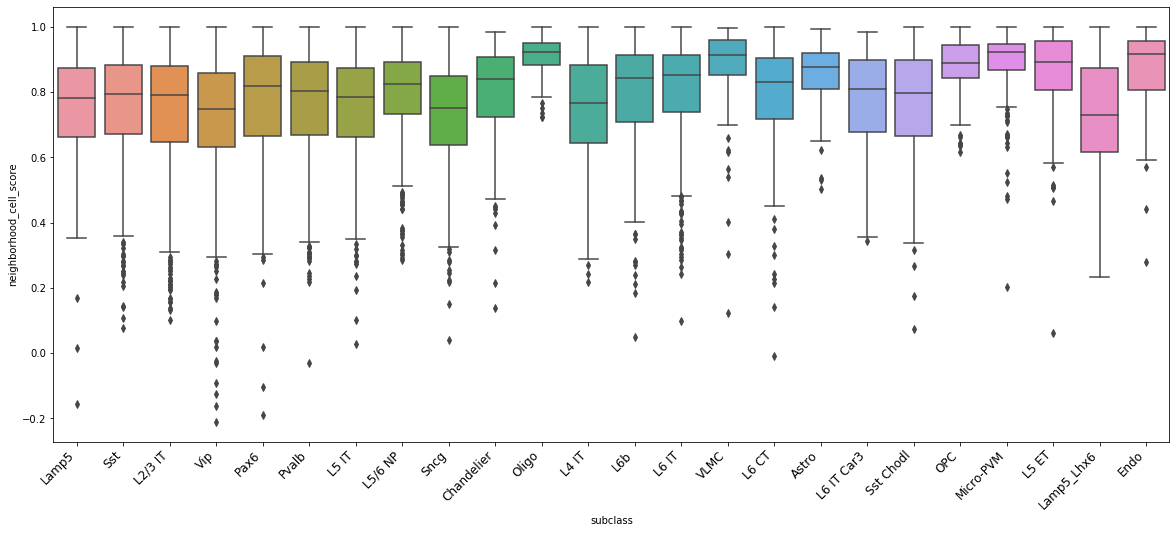

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=neighborhood_score, x='subclass', y='neighborhood_cell_score', ax=ax)
_ = plt.xticks(rotation = 45, fontsize=12, ha='right')

In [8]:
neighborhood_score.describe()

,neighborhood_cell_score
count,10772.000000
mean,0.772220
std,0.163127
min,-0.210955
25%,0.682752
50%,0.809525
75%,0.896379
max,1.000000


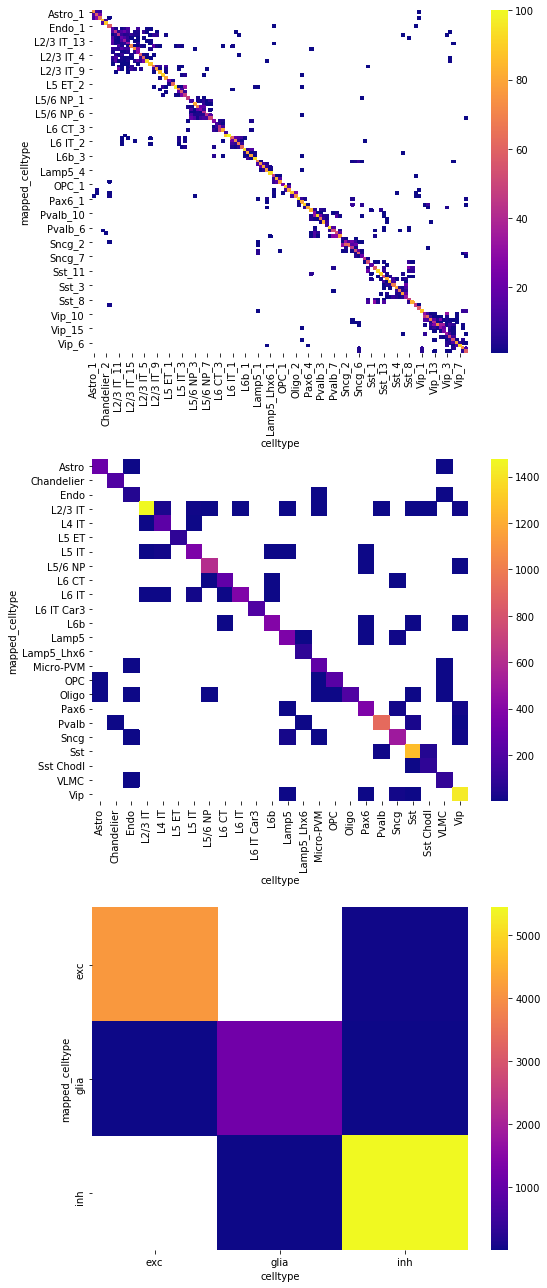

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(8, 18))
                       
for i, level in enumerate(['cluster', 'subclass', 'class']):
    sns.heatmap(confusion_matrix[level].dropna(how='all'), cmap='plasma', ax=ax[i])
plt.tight_layout()

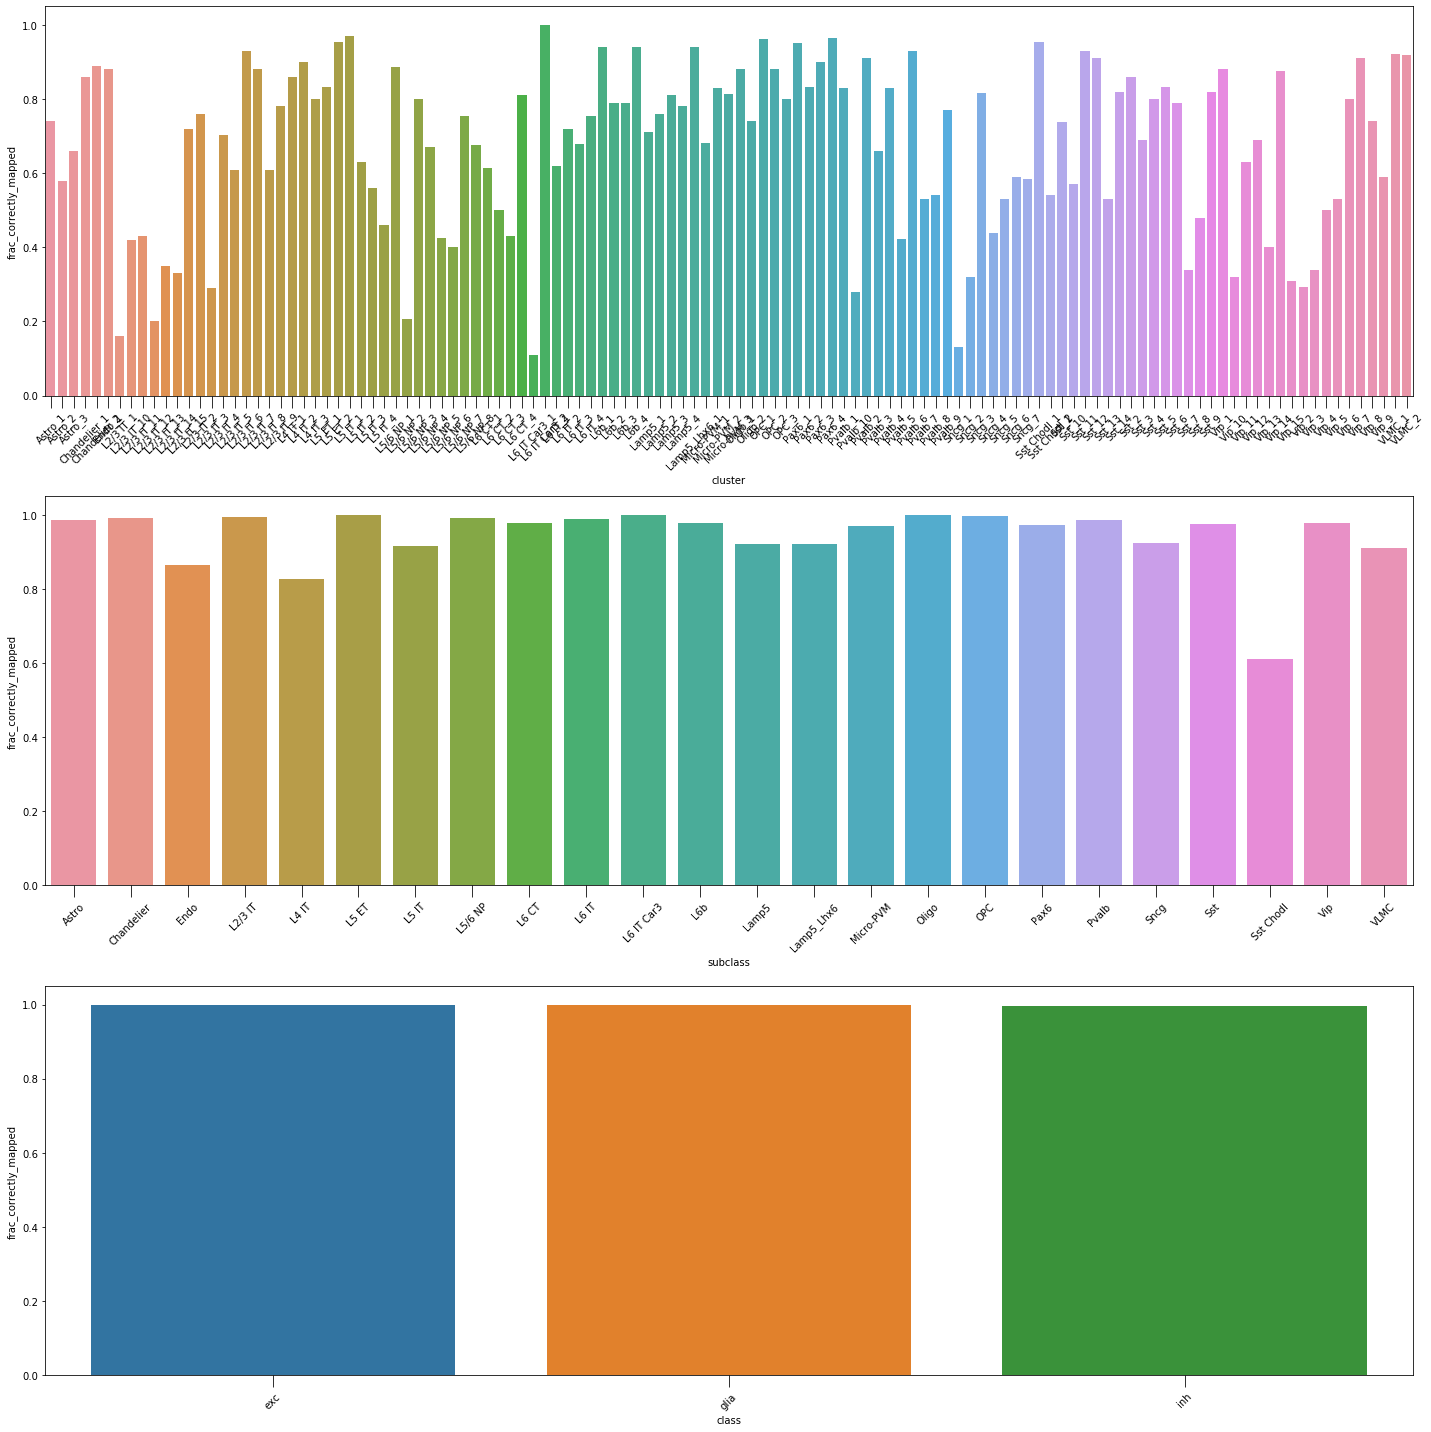

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

for i, level in enumerate(['cluster', 'subclass', 'class']):
    sns.barplot(data=fraction_mapped[level].dropna(how='all'), x='celltype', y='frac_correctly_mapped', ax=ax[i])
    ax[i].set_xlabel(level)
    ax[i].tick_params(axis='x', rotation = 45, size=12)
plt.tight_layout()